In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, cv2

In [2]:
# 데이터 로딩 및 전처리
def load_data(data_dir, image_size=(96,96)):
    images, labels = [], []
    for label, category in enumerate(["no_person", "person"]):
        path = os.path.join(data_dir, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
    images = np.expand_dims(np.array(images)/255.0, -1)  # shape: (N, 96, 96, 1)
    return images, np.array(labels)

X, y = load_data("dataset")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
# 모델 구성

model = Sequential([
    Conv2D(8, (3,3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(2),  # 두 클래스
    Softmax()  # 확률화
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # y_train이 0/1이면 OK
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                123920    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3

In [4]:
# 학습

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,        # 5번 연속 악화되면 멈춤
    restore_best_weights=True
)

# 데이터 증강기 정의
datagen = ImageDataGenerator(
    rotation_range=10,       # 회전 ±10도
    zoom_range=0.1,          # 확대/축소 10%
    horizontal_flip=True     # 좌우 반전
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # ← 증강된 이미지 사용
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
10/10 [==============================] - 0s 31ms/step - loss: 0.7788 - accuracy: 0.4696 - val_loss: 0.6902 - val_accuracy: 0.5190
Epoch 2/50
10/10 [==============================] - 0s 23ms/step - loss: 0.6904 - accuracy: 0.5911 - val_loss: 0.6899 - val_accuracy: 0.5063
Epoch 3/50
10/10 [==============================] - 0s 23ms/step - loss: 0.6866 - accuracy: 0.5431 - val_loss: 0.6767 - val_accuracy: 0.5063
Epoch 4/50
10/10 [==============================] - 0s 22ms/step - loss: 0.6707 - accuracy: 0.5655 - val_loss: 0.6391 - val_accuracy: 0.7089
Epoch 5/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6487 - accuracy: 0.6518 - val_loss: 0.6043 - val_accuracy: 0.8101
Epoch 6/50
10/10 [==============================] - 0s 23ms/step - loss: 0.6246 - accuracy: 0.6709 - val_loss: 0.5703 - val_accuracy: 0.8228
Epoch 7/50
10/10 [==============================] - 0s 23ms/step - loss: 0.5891 - accuracy: 0.7220 - val_loss: 0.5518 - val_accuracy: 0.7848
Epoch 8/50
10

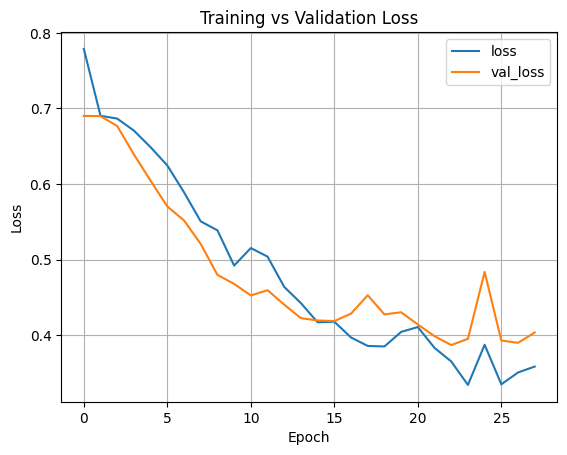

In [5]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], label='loss')
plt.plot(history.epoch, metrics['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(X_test)             # shape: (N, 2)
y_pred = np.argmax(y_pred_prob, axis=1)         # 클래스 확률 중 최대값의 index

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["no_person", "person"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

   no_person       0.81      0.90      0.85        39
      person       0.89      0.80      0.84        40

    accuracy                           0.85        79
   macro avg       0.85      0.85      0.85        79
weighted avg       0.85      0.85      0.85        79

Confusion Matrix:
[[35  4]
 [ 8 32]]


In [7]:
# 대표 데이터셋 생성기 (정적 양자화용)
def representative_dataset_gen():
    for i in range(min(100, len(X_train))):
        image = X_train[i]
        image = np.expand_dims(image, axis=0).astype(np.float32)  # (1,96,96,1)
        yield [image]

# 정적 양자화 (완전 int8)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

try:
    tflite_model_int8 = converter.convert()
    with open("person_detection_quantized_int8.tflite", "wb") as f:
        f.write(tflite_model_int8)
    print("정적 양자화 모델 저장 완료: person_detection_quantized_int8.tflite")
except Exception as e:
    print("정적 양자화 실패:", e)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmp73r4ck05\assets
정적 양자화 모델 저장 완료: person_detection_quantized_int8.tflite


In [8]:
with open("mobilenet_person_detection_quant.tflite", "wb") as f:
    f.write(tflite_model_int8)


In [9]:
!xxd -i person_detection_quantized_int8.tflite > person_detection_model.cc